In [1]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.formula.api as smf

from regtabletotext import prettify_result
from statsmodels.regression.rolling import RollingOLS
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
from joblib import Parallel, delayed, cpu_count
from itertools import product

In [2]:
tidy_finance = sqlite3.connect(database="data/tidy_finance_python.sqlite")

crsp_monthly = (pd.read_sql_query(
    sql="SELECT permno, date, industry, ret_excess FROM crsp_monthly",
    con=tidy_finance,
    parse_dates={"date"})
  .dropna()
)

factors_ff3_monthly = pd.read_sql_query(
  sql="SELECT date, mkt_excess FROM factors_ff3_monthly",
  con=tidy_finance,
  parse_dates={"date"}
)

crsp_monthly = (crsp_monthly
  .merge(factors_ff3_monthly, how="left", on="date")
)

In [3]:
model_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess",
    data=crsp_monthly.query("permno == 14593"))
  .fit()
)
prettify_result(model_beta)

OLS Model:
ret_excess ~ mkt_excess

Coefficients:
            Estimate  Std. Error  t-Statistic  p-Value
Intercept      0.010       0.005        2.048    0.041
mkt_excess     1.373       0.108       12.768    0.000

Summary statistics:
- Number of observations: 528
- R-squared: 0.237, Adjusted R-squared: 0.235
- F-statistic: 163.030 on 1 and 526 DF, p-value: 0.000



In [4]:
window_size = 60
min_obs = 48

valid_permnos = (crsp_monthly
  .dropna()
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query(f"counts > {window_size}+1")
)

In [5]:
permno_information = (crsp_monthly
  .merge(valid_permnos, how="inner", on="permno")
  .groupby(["permno"])
  .aggregate(first_date=("date", "min"),
             last_date=("date", "max"))
  .reset_index()
)

In [6]:
unique_permno = crsp_monthly["permno"].unique()
unique_month = factors_ff3_monthly["date"].unique()

all_combinations = pd.DataFrame(
  product(unique_permno, unique_month), 
  columns=["permno", "date"]
)

In [7]:
returns_monthly = (all_combinations
  .merge(crsp_monthly.get(["permno", "date", "ret_excess"]), 
         how="left", on=["permno", "date"])
  .merge(permno_information, how="left", on="permno")
  .query("(date >= first_date) & (date <= last_date)")
  .drop(columns=["first_date", "last_date"])
  .merge(crsp_monthly.get(["permno", "date", "industry"]),
         how="left", on=["permno", "date"])
  .merge(factors_ff3_monthly, how="left", on="date")
)

In [8]:
def roll_capm_estimation(data, window_size, min_obs):
    """Calculate rolling CAPM estimation."""
    
    data = data.sort_values("date")

    result = (RollingOLS.from_formula(
      formula="ret_excess ~ mkt_excess",
      data=data,
      window=window_size,
      min_nobs=min_obs,
      missing="drop")
      .fit()
      .params.get("mkt_excess")
    )
    
    result.index = data.index
    
    return result

In [9]:
examples = pd.DataFrame({
  "permno": [14593, 10107, 93436, 17778],
  "company": ["Apple", "Microsoft", "Tesla", "Berkshire Hathaway"]
})

In [10]:
beta_example = (returns_monthly
  .merge(examples, how="inner", on="permno")
  .groupby(["permno"])
  .apply(lambda x: x.assign(
    beta=roll_capm_estimation(x, window_size, min_obs))
  )
  .reset_index(drop=True)
  .dropna()
)

/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_55421/2339352254.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


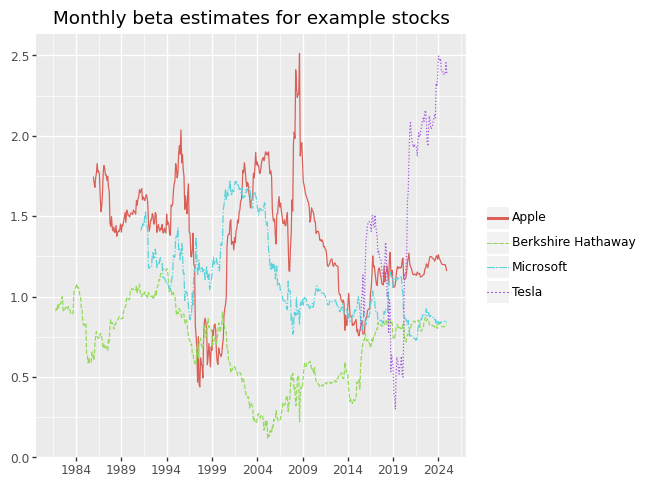

In [11]:
plot_beta = (
  ggplot(beta_example, 
         aes(x="date", y="beta", color="company", linetype="company")) + 
  geom_line() + 
  labs(x="", y="", color="", linetype="",
       title="Monthly beta estimates for example stocks") +
  scale_x_datetime(breaks=date_breaks("5 year"), labels=date_format("%Y")) 
)
plot_beta.draw()

In [12]:
def roll_capm_estimation_for_joblib(permno, group):
    """Calculate rolling CAPM estimation using joblib."""
    
    group = group.sort_values(by="date")

    beta_values = (RollingOLS.from_formula(
        formula="ret_excess ~ mkt_excess",
        data=group,
        window=window_size,
        min_nobs=min_obs,
        missing="drop"
      )
      .fit()
      .params.get("mkt_excess")
    )
    
    result = pd.DataFrame(beta_values)
    result.columns = ["beta"]
    result["date"] = group["date"].values
    result["permno"] = permno
    
    return result

permno_groups = (returns_monthly
  .merge(valid_permnos, how="inner", on="permno")
  .groupby("permno", group_keys=False)
)

n_cores = cpu_count()-1

beta_monthly = (
  pd.concat(
    Parallel(n_jobs=n_cores)
    (delayed(roll_capm_estimation_for_joblib)(name, group)
    for name, group in permno_groups)
  )
  .dropna()
  .rename(columns={"beta": "beta_monthly"})
)

In [13]:
beta_monthly.to_sql(
    name="beta_monthly",
    con=tidy_finance,
    if_exists="replace",
    index=False
)

2143928